In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
import argparse
import logging
import sys
import pandas as pd

from scipy import integrate
from src.precession.config import Config
from src.precession.planet import Planet

from src.precession.precession import solve



## Three body central force problem Sun-Mercury-Jupiter system

*Note* Assume the Sun is stationary at origin

Terms for Mercury, Jupiter and the Sun have subscripts M, K and S respectively

$$
\mathscr{L} = \frac{1}{2}m_M \dot{r_M}^2 + \frac{1}{2}m_M r_M^2 \dot{\theta_M}^2 + \frac{1}{2}m_J \dot{r_J}^2 + \frac{1}{2}m_J r_J^2 \dot{\theta_J}^2 + \frac{G m_S m_M}{r_M} + \frac{G m_S m_J}{r_J} + \frac{G m_J m_M}{r_{JM}}
$$

where
$$
r_{JM}^2 = r_J^2 + r_M^2 - 2r_Jr_Mcos(\theta_M - \theta_J)
$$



This gives

$$
\frac{\partial \mathscr{L}}{\dot{r_M}} = m_M \dot{r_M}
$$

$$
\frac{\partial \mathscr{L}}{\dot{r_J}} = m_J \dot{r_J}
$$

$$
\frac{\partial \mathscr{L}}{\partial \dot{\theta_M}} = m_M r_M^2 \dot{\theta_M}
$$

$$
\frac{\partial \mathscr{L}}{\partial \dot{\theta_J}} = m_J r_J^2 \dot{\theta_J}
$$

$$
\frac{\partial \mathscr{L}}{\partial r_M} = m_M r_M \dot{\theta_M}^2 - \frac{Gm_Sm_M}{r_M^2} - \frac{Gm_Jm_M}{r_{JM}^2} \frac{\partial r_{JM}}{\partial r_M}
$$

$$
\frac{\partial \mathscr{L}}{\partial r_J} = m_J r_J \dot{\theta_J}^2 - \frac{Gm_Sm_J}{r_J^2} - \frac{Gm_Jm_M}{r_{JM}^2} \frac{\partial r_{JM}}{\partial r_J}
$$

$$
\frac{\partial \mathscr{L}}{\partial \theta_M} = - \frac{Gm_Jm_M}{r_{JM}^2} \frac{\partial r_{JM}}{\partial \theta_M}
$$

$$
\frac{\partial \mathscr{L}}{\partial \theta_J} = - \frac{Gm_Jm_M}{r_{JM}^2} \frac{\partial r_{JM}}{\partial \theta_J}
$$


Where

$$
\frac{\partial r_{JM}}{\partial r_M} = \frac{r_M - r_Jcos(\theta_M - \theta_J)}{r_{JM}}
$$

$$
\frac{\partial r_{JM}}{\partial r_J} = \frac{r_J - r_Mcos(\theta_M - \theta_J)}{r_{JM}}
$$

$$
\frac{\partial r_{JM}}{\partial \theta_M} = - \frac{r_Jr_Msin(\theta_M - \theta_J)}{r_{JM}}
$$

$$
\frac{\partial r_{JM}}{\partial \theta_J} = \frac{r_Jr_Msin(\theta_M - \theta_J)}{r_{JM}}
$$

For $ r_M $

$$
\frac{d}{dt}(\frac{\partial \mathscr{L}}{\partial \dot{r_M}}) = \frac{\partial \mathscr{L}}{\partial r_M}
$$

$$
\ddot{r_M} = r_M \dot{\theta_M}^2 - \frac{Gm_S}{r_M^2} - \frac{Gm_J(r_M - r_Jcos(\theta_M - \theta_J))}{r_{JM}^3}
$$

For $ r_J $

$$
\frac{d}{dt}(\frac{\partial \mathscr{L}}{\partial \dot{r_J}}) = \frac{\partial \mathscr{L}}{\partial r_J}
$$

$$
\ddot{r_J} = r_J \dot{\theta_J}^2 - \frac{Gm_S}{r_J^2} - \frac{Gm_M(r_J - r_Mcos(\theta_M - \theta_J))}{r_{JM}^3}
$$


For $ \theta_M $

$$
\frac{d}{dt}(\frac{\partial \mathscr{L}}{\partial \dot{\theta_M}}) = \frac{\partial \mathscr{L}}{\partial \theta_M}
$$

$$
\frac{d}{dt}(r_M^2 \dot{\theta_M}) = \frac{Gm_Jr_Jr_Msin(\theta_M - \theta_J)}{r_{JM}^3}
$$


For $ \theta_J $

$$
\frac{d}{dt}(\frac{\partial \mathscr{L}}{\partial \dot{\theta_J}}) = \frac{\partial \mathscr{L}}{\partial \theta_J}
$$

$$
\frac{d}{dt}(r_J^2 \dot{\theta_J}) = - \frac{Gm_Mr_Jr_Msin(\theta_M - \theta_J)}{r_{JM}^3}
$$


Separating variables to solve ODEs. 
$$ \dot{r_M} = V_M $$
$$ \dot{r_J} = V_J $$
$$ \dot{\theta_M} = \Omega_M $$
$$ \dot{\theta_J} = \Omega_J $$
$$
\dot{V_M} = r_M \Omega_M^2 - \frac{Gm_S}{r_M^2} - \frac{Gm_J(r_M - r_Jcos(\theta_M - \theta_J))}{(r_J^2 + r_M^2 - 2r_Jr_Mcos(\theta_M - \theta_J))^\frac{3}{2}}
$$
$$
\dot{V_J} = r_J \Omega_J^2 - \frac{Gm_S}{r_J^2} - \frac{Gm_M(r_J - r_Mcos(\theta_M - \theta_J))}{(r_J^2 + r_M^2 - 2r_Jr_Mcos(\theta_M - \theta_J))^\frac{3}{2}}
$$
$$
\dot{\Omega_M} = \frac{Gm_Jr_Jsin(\theta_M - \theta_J)}{r_M(r_J^2 + r_M^2 - 2r_Jr_Mcos(\theta_M - \theta_J))^\frac{3}{2}} - \frac{2V_M\Omega_M}{r_M}
$$
$$
\dot{\Omega_J} = - \frac{Gm_Mr_Msin(\theta_M - \theta_J)}{r_J^2(r_J + r_M^2 - 2r_Jr_Mcos(\theta_M - \theta_J))^\frac{3}{2}} - \frac{2V_J\Omega_J}{r_J}
$$

This system of equations can be solved using appropriate boundary conditions

In [2]:
config = Config.load("src/precession/config.yml")
planet = Planet.load(config, "src/precession/jupiter.yml")
mercury = Planet.load(config, "src/precession/mercury.yml")

In [3]:
df = solve(config, planet, mercury)

In [4]:
df.head(50)

,r_p,theta_p,v_p,omega_p,r_m,theta_m,v_m,omega_m,time
0,5.203,3.141593,0.000000e+00,0.523847,0.307278,0.000000,0.000000,40.636056,0.000000
1,5.203,3.141594,3.164766e-09,0.523847,0.307278,0.000095,0.000202,40.636056,0.000002
2,5.203,3.141606,3.481243e-08,0.523847,0.307278,0.001044,0.002227,40.636049,0.000026
3,5.203,3.141728,3.512891e-07,0.523847,0.307281,0.010535,0.022470,40.635286,0.000259
4,5.203,3.141990,1.028766e-06,0.523847,0.307303,0.030852,0.065791,40.629450,0.000759
5,5.203,3.142252,1.706242e-06,0.523847,0.307347,0.051164,0.109076,40.617892,0.001259
6,5.203,3.142514,2.383719e-06,0.523847,0.307412,0.071469,0.152301,40.600625,0.001759
7,5.203,3.142776,3.061195e-06,0.523847,0.307499,0.091764,0.195442,40.577670,0.002259
8,5.203,3.143038,3.738671e-06,0.523847,0.307607,0.112045,0.238475,40.549054,0.002759
9,5.203,3.143300,4.416147e-06,0.523847,0.307737,0.132312,0.281376,40.514810,0.003259


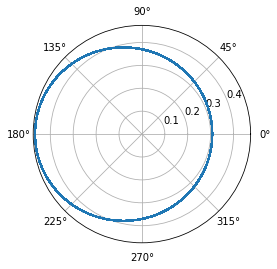

In [5]:
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
ax.plot(df["theta_m"], df["r_m"])
plt.show()

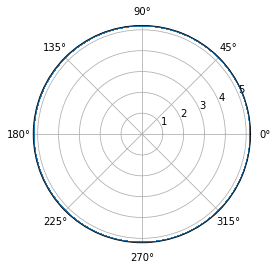

In [6]:
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
ax.plot(df["theta_p"], df["r_p"])
plt.show()